# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os #for import
import random
import matplotlib.pyplot as plt # data ploting
import cv2 #processing images

importing image labels and paths

In [2]:
path = '/kaggle/input/agricultural-crops-image-classification/Agricultural-crops'
classes = sorted(os.listdir(path), key=lambda s: s.lower()) #import class folders and sort ingoring case
image_paths = [] #store paths
labels = [] #store labels

for c in classes:
    class_folder = path + "/" + c #for each class define path
    for image in os.listdir(class_folder): 
        image_path = class_folder + "/" + image #for each image add to dataframe by path and label, i.e class
        image_paths.append(image_path)
        labels.append(c)

class_labels = np.unique(labels) #class labels
num_classes = len(class_labels)
# map labels to numerical values
label_mapping = {label: i for i, label in enumerate(class_labels)}
print(label_mapping)
labels = np.array([label_mapping[label] for label in labels]) #change from string to index from mapping
image_paths = np.array(image_paths) #convert to numpy array
df = pd.DataFrame({"image_paths":image_paths,"labels":labels}) #create dataframe
image_paths = df['image_paths']

{'Cherry': 0, 'Coffee-plant': 1, 'Cucumber': 2, 'Fox_nut(Makhana)': 3, 'Lemon': 4, 'Olive-tree': 5, 'Pearl_millet(bajra)': 6, 'Tobacco-plant': 7, 'almond': 8, 'banana': 9, 'cardamom': 10, 'chilli': 11, 'clove': 12, 'coconut': 13, 'cotton': 14, 'gram': 15, 'jowar': 16, 'jute': 17, 'maize': 18, 'mustard-oil': 19, 'papaya': 20, 'pineapple': 21, 'rice': 22, 'soyabean': 23, 'sugarcane': 24, 'sunflower': 25, 'tea': 26, 'tomato': 27, 'vigna-radiati(Mung)': 28, 'wheat': 29}


Dataframe:

In [3]:
df.head()

,image_paths,labels
0,/kaggle/input/agricultural-crops-image-classif...,8
1,/kaggle/input/agricultural-crops-image-classif...,8
2,/kaggle/input/agricultural-crops-image-classif...,8
3,/kaggle/input/agricultural-crops-image-classif...,8
4,/kaggle/input/agricultural-crops-image-classif...,8


# Image Data Generation
This function will help to convert images into datasets

it also handles normaliztion

In [4]:
def preprocess_image(image_path, target_size=(224, 224), normalize=True, show=False):
    try:
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        # Resize the image to the target size
        image = cv2.resize(image, target_size)
        if normalize:
            # Convert pixel values to the range [0, 1]
            image = image.astype(np.float32) / 255.0
        if show:
            plt.imshow(image)
            plt.axis('off')  # Turn off axis labels and ticks
            plt.show()
        return image
    except Exception as e:
        print(f"Error preprocessing image: {str(e)}")
        return None

parameters for function

In [5]:
image_size = 128 # size of transofrmed image
normalize = True
show = False

In [6]:
images=[] #store processed images
for image_path in image_paths:
    image=preprocess_image(image_path, (image_size, image_size), normalize, show)
    images.append(image)
images = np.array(images) #convert to numpy array

flatten images:

In [7]:
images = images.reshape(images.shape[0], image_size * image_size * 3) #flatten images

Get number of samples in datasets, and number of pixels per picture

In [8]:
num_samples, num_pixels = images.shape

# Dividing data into test, train and validation
- 10% test set
- 90% trian and validation

In [9]:
def train_test_split(images, labels, test_size=0.1, num_rep=1, rand=True, strat=True):
    num_samples, _ = images.shape
    num_test = int(test_size * num_samples)
    indices = list(range(num_samples)) #indices of each image

    class_indices = [np.where(labels == c)[0] for c in range(num_classes)]
    # will return arrays of indices corrisponding to it's unique class
    
    # Initialize test_indices and train_indices lists
    test_indices = []
    train_indices = []
    
    # for function with number of repeitions to randomize our training and test sets
    for _ in range(num_rep):
        if strat:
            if rand:
                # permutates indices in each class(subarray)
                class_indices = [np.random.permutation(class_ids) for class_ids in class_indices]
            
            # Calculate the number of samples from each class for testing
            num_samples_per_class_test = [int(len(class_ids) * test_size) for class_ids in class_indices]

            for i, class_ids in enumerate(class_indices):
                test_indices.extend(class_ids[:num_samples_per_class_test[i]])
                train_indices.extend(class_ids[num_samples_per_class_test[i]:])
            
            # Shuffle the test and train indices if rand is True
            if rand:
                random.shuffle(test_indices)
                random.shuffle(train_indices)
        else:
            if rand:
                # Shuffle the indices randomly
                indices = np.random.permutation(num_samples)
            # Split the indices into training and testing sets
            
            test_indices = indices[:num_test]
            train_indices = indices[num_test:]
            
        if not rand: 
            break

    # Create the training and testing sets
    Xtr, Ytr = images[train_indices], labels[train_indices]
    Xte, Yte = images[test_indices], labels[test_indices]

    return Xtr, Xte, Ytr, Yte

In [10]:
Xtr, Xte, Ytr, Yte = train_test_split(images, labels, 0.1) # (10%) x (image_size * image_size * 3)

In [11]:
Xtr.shape

(757, 49152)

# 5 Fold Cross Validation

instead of creating new datasets, I will work with indices

Also, I will implement randomization so that each time I repeat cross validation, the data shuffles

In [12]:
num_folds = 5
num_rep = 1
rand = True
strat = True #stratification

stratification - the arrangement or classification of something into different groups.

In [13]:
def generate_cross_validation_pairs(X, y, num_folds=5, num_rep = 1, rand = True, strat = True):
    pairs = [] #store validation and train folds
    indices = list(range(len(y))) #indices of each image

    class_indices = [np.where(y == c)[0] for c in range(len(np.unique(y)))] 
    # will return arrays of indices corrisponding to it's unique class
    # for function with number of repeitions to randomize out folds
    for _ in range(num_rep):
        if strat:
            if rand:
                # permutates indices in each class(subarray)
                class_indices = [np.random.permutation(class_ids) for class_ids in class_indices]
            folds = [] #store divided indices for each fold
            #splites each class into num_folds arrays
            class_indices_split = [np.array_split(c, num_folds) for c in class_indices]

            for classes in zip(*class_indices_split):
                folds.append(np.concatenate(classes))
        else:
            if rand:
                #permutates indices
                random.shuffle(indices)
            #splits array into folds
            folds = np.array_split(indices, num_folds)

        for fold_idx in range(num_folds):
            val_fold = folds[fold_idx]
            train_folds = np.concatenate(np.delete(folds, fold_idx, axis=0))
            pairs.append([train_folds, val_fold])

        if not rand: 
            break
    return pairs;

In [14]:
pairs = generate_cross_validation_pairs(Xtr, Ytr)

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [15]:
pairs[0][1] #validation set for first fold

array([723, 392, 261, 320, 248, 168, 172, 681, 718, 453, 550, 595, 160,
       448, 617, 693,   9, 672, 635, 673, 485, 440, 106, 406, 298, 515,
       361, 343, 544, 322, 137, 294, 611, 511, 220, 359,  21, 659, 525,
       447, 504, 332, 183, 293, 417, 588, 381, 540, 374,  94, 352,   7,
       158, 360, 670,   6, 602,  15, 463,  83,  11, 700, 325, 380, 402,
       486, 432, 566, 503, 339, 238, 228, 484, 664, 597, 668, 562,  51,
        96, 534, 390, 257, 418, 680, 319, 653, 382, 151, 622, 357, 695,
       556, 297, 372, 117,  16, 223, 304,  77, 252, 754,  43, 461, 256,
       421, 487, 527, 139, 710, 596, 728, 226, 214, 126, 386, 514,  79,
        17, 364, 573, 113, 266, 638, 389, 154, 516, 509, 275, 708, 149,
       428, 637, 253, 396, 189, 174, 348, 620, 692,  72, 612, 519, 276,
       497, 118, 698, 583, 185, 175, 344, 500,  13, 337, 177, 472, 212,
       190,  89, 367, 201, 397, 188, 271, 743, 324, 474])

Check for errors

In [16]:
print(image_paths[pairs[2][0][0]])
print(list(label_mapping.keys())[list(label_mapping.values()).index(labels[pairs[2][0][0]])])

/kaggle/input/agricultural-crops-image-classification/Agricultural-crops/Tobacco-plant/images41.jpg
Tobacco-plant


# Algorithms

In [17]:
# Define regularization strength and learning rate
reg_strength = 0.01
learning_rate = 0.1

# Define the function to evaluate accuracy
def evaluate_accuracy(X, y, W):
    scores = np.dot(X, W)
    predicted_classes = np.argmax(scores, axis=1)
    accuracy = np.mean(predicted_classes == y)
    return accuracy

# Split the data into train, validation, and test sets using 5-fold cross-validation
def split_data(images, labels, pairs, fold):
    train_indices, val_indices = pairs[fold]
    X_train, y_train = images[train_indices], labels[train_indices]
    X_val, y_val = images[val_indices], labels[val_indices]
    return X_train, y_train, X_val, y_val

In [18]:
# Define the Softmax function
def softmax(scores):
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

# Define the cross-entropy loss function with regularization
def softmax_compute_loss(X, y, W, reg_strength):
    num_samples = X.shape[0]
    scores = np.dot(X, W)
    probs = softmax(scores)
    epsilon = 1e-8  # Small constant to prevent division by zero
    loss = -np.log(probs[range(num_samples), y] + epsilon)
    data_loss = np.sum(loss) / num_samples
    reg_loss = 0.5 * reg_strength * np.sum(W * W)
    total_loss = data_loss + reg_loss
    return total_loss

# Define the function to compute gradients of the loss function
def softmax_compute_gradient(X, y, W, reg_strength):
    num_samples = X.shape[0]
    scores = np.dot(X, W)
    probs = softmax(scores)
    probs[range(num_samples), y] -= 1
    probs /= num_samples
    gradient = np.dot(X.T, probs)
    gradient += reg_strength * W
    return gradient

# Define the gradient descent optimization for Softmax
def softmax_gradient_descent(X, y, W, learning_rate, reg_strength, num_epochs, batch_size):
    num_samples = X.shape[0]
    loss_history = []

    for epoch in range(num_epochs):
        for i in range(0, num_samples, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            gradient = softmax_compute_gradient(X_batch, y_batch, W, reg_strength)
            W -= learning_rate * gradient

        loss = softmax_compute_loss(X, y, W, reg_strength)
        loss_history.append(loss)
        #print(f'Softmax - Epoch {epoch + 1}/{num_epochs}, Loss: {loss}')
        
    # Plot the training loss over epochs
    plt.plot(loss_history)
    plt.title('Softmax Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    return W, loss_history

In [19]:
# Define the SVM loss function with regularization
def svm_compute_loss(X, y, W, reg_strength):
    num_samples = X.shape[0]
    scores = np.dot(X, W)
    correct_scores = scores[range(num_samples), y]
    margins = scores - correct_scores[:, np.newaxis] + 1
    margins[range(num_samples), y] = 0
    margins = np.maximum(0, margins)

    loss = np.sum(margins) / num_samples
    reg_loss = 0.5 * reg_strength * np.sum(W * W)
    total_loss = loss + reg_loss
    return total_loss

# Define the SVM gradient computation with regularization
def svm_compute_gradient(X, y, W, reg_strength):
    num_samples = X.shape[0]
    scores = np.dot(X, W)
    correct_scores = scores[range(num_samples), y]
    margins = scores - correct_scores[:, np.newaxis] + 1
    margins[range(num_samples), y] = 0
    margins = (margins > 0).astype(float)
    row_sum = np.sum(margins, axis=1)
    margins[range(num_samples), y] -= row_sum
    gradient = np.dot(X.T, margins)
    gradient /= num_samples
    gradient += reg_strength * W
    return gradient

# Define the gradient descent optimization for SVM
def svm_gradient_descent(X, y, W, learning_rate, reg_strength, num_epochs, batch_size):
    num_samples = X.shape[0]
    loss_history = []

    for epoch in range(num_epochs):
        for i in range(0, num_samples, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            gradient = svm_compute_gradient(X_batch, y_batch, W, reg_strength)
            W -= learning_rate * gradient

        loss = svm_compute_loss(X, y, W, reg_strength)
        loss_history.append(loss)
        #print(f'SVM - Epoch {epoch + 1}/{num_epochs}, Loss: {loss}')

    # Plot the training loss over epochs
    plt.plot(loss_history)
    plt.title('Svm Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    return W, loss_history

Fold 1/5
Training Softmax Regression...


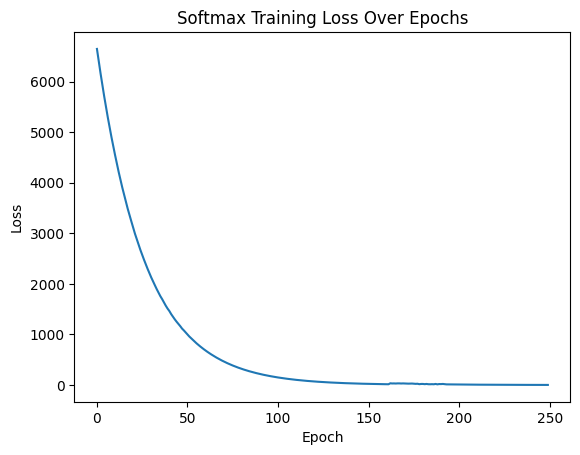

Training SVM...


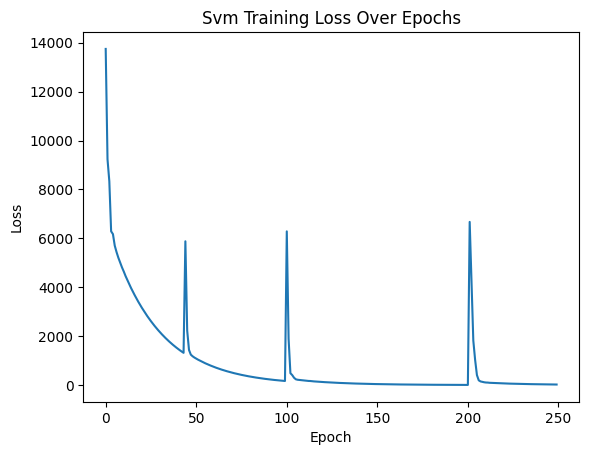

Softmax Regression Accuracy (Fold 1): 0.1927710843373494
SVM Accuracy (Fold 1): 0.22289156626506024
Fold 2/5
Training Softmax Regression...


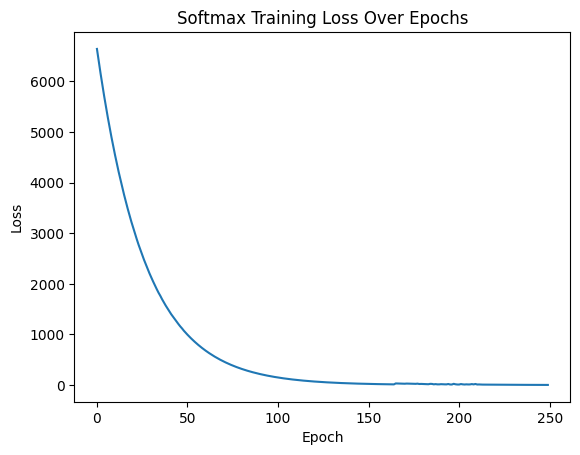

Training SVM...


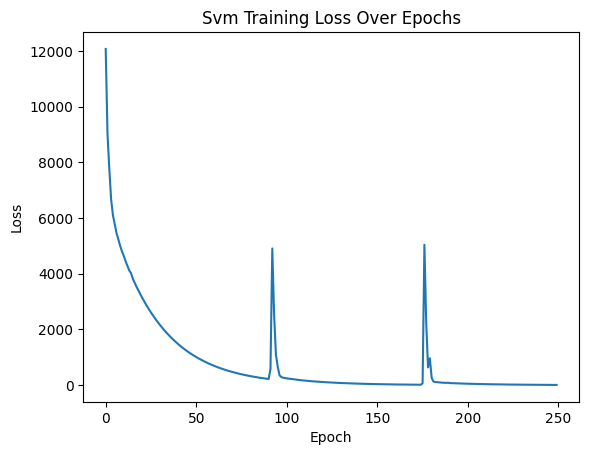

Softmax Regression Accuracy (Fold 2): 0.20253164556962025
SVM Accuracy (Fold 2): 0.2088607594936709
Fold 3/5
Training Softmax Regression...


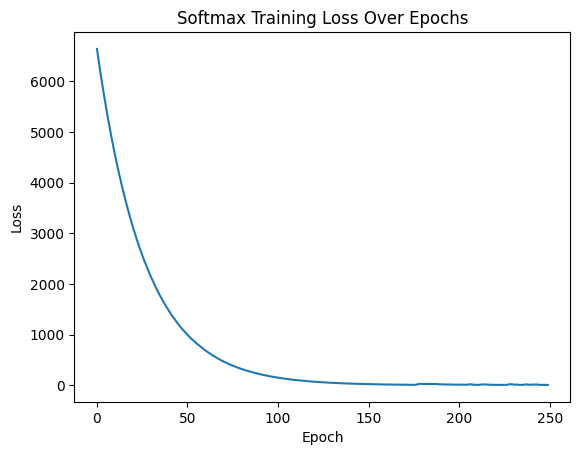

Training SVM...


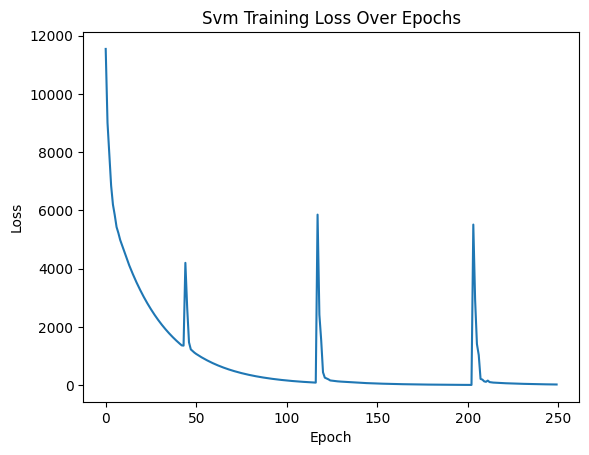

Softmax Regression Accuracy (Fold 3): 0.18543046357615894
SVM Accuracy (Fold 3): 0.17218543046357615
Fold 4/5
Training Softmax Regression...


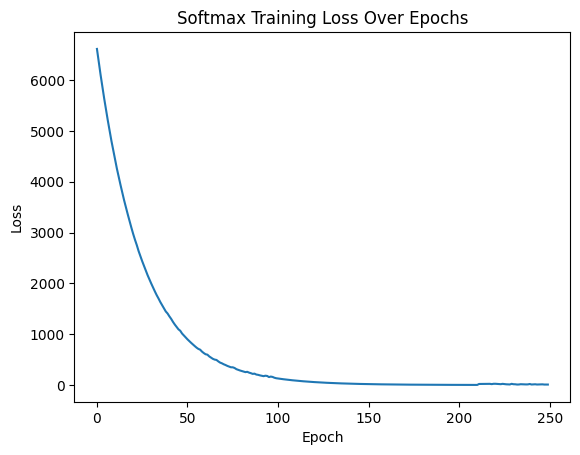

Training SVM...


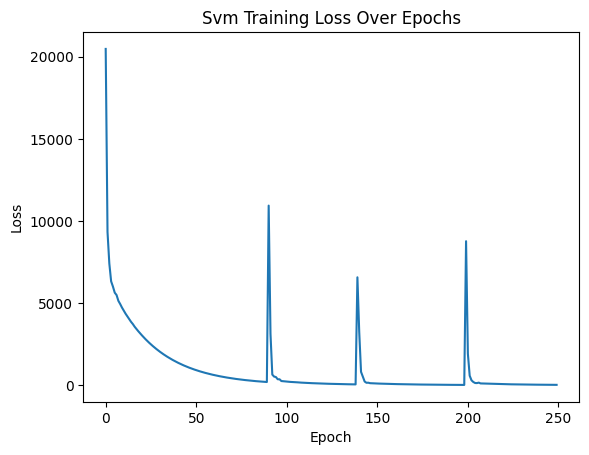

Softmax Regression Accuracy (Fold 4): 0.22377622377622378
SVM Accuracy (Fold 4): 0.24475524475524477
Fold 5/5
Training Softmax Regression...


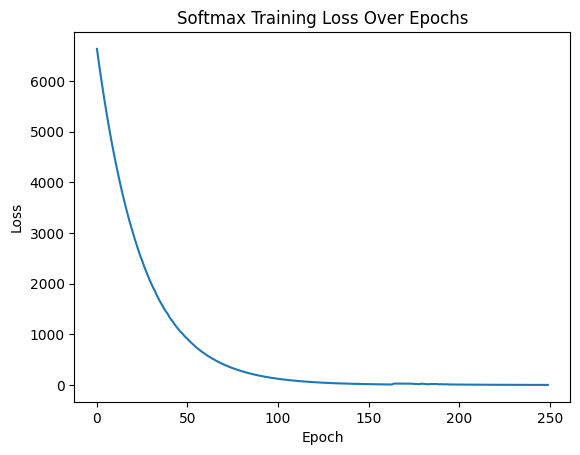

Training SVM...


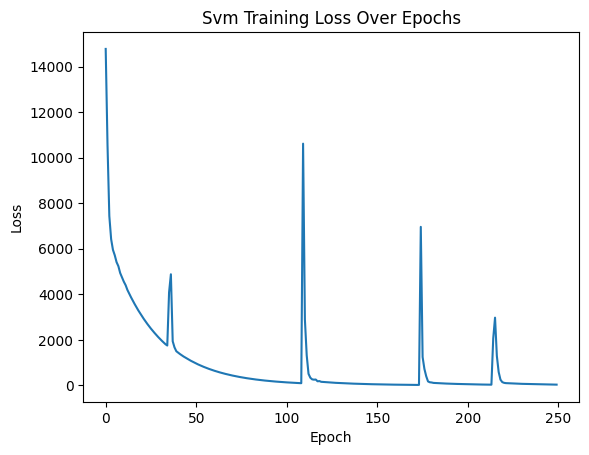

Softmax Regression Accuracy (Fold 5): 0.28776978417266186
SVM Accuracy (Fold 5): 0.28776978417266186
Average Softmax Regression Accuracy: 0.21845584028640283
Average SVM Accuracy: 0.2272925570300428
The best algorithm is: SVM
Softmax Regression Test Accuracy: 0.8472222222222222
SVM Test Accuracy: 0.8611111111111112


In [20]:
softmax_accuracies = []
svm_accuracies = []
num_epochs = 250

for fold in range(num_folds):
    print(f'Fold {fold + 1}/{num_folds}')
    X_train, y_train, X_val, y_val = split_data(images, labels, pairs, fold)
    
    # Initialize weights for Softmax Regression and SVM
    num_features = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    W_softmax = np.random.randn(num_features, num_classes)
    W_svm = np.random.randn(num_features, num_classes)
    
    # Train Softmax Regression
    print('Training Softmax Regression...')
    W_softmax, _ = softmax_gradient_descent(X_train, y_train, W_softmax, learning_rate, reg_strength, num_epochs, batch_size=32)
    
    # Train SVM
    print('Training SVM...')
    W_svm, _ = svm_gradient_descent(X_train, y_train, W_svm, learning_rate, reg_strength, num_epochs, batch_size=32)
    
    # Evaluate accuracy on the validation set
    softmax_accuracy = evaluate_accuracy(X_val, y_val, W_softmax)
    svm_accuracy = evaluate_accuracy(X_val, y_val, W_svm)
    
    softmax_accuracies.append(softmax_accuracy)
    svm_accuracies.append(svm_accuracy)
    print(f'Softmax Regression Accuracy (Fold {fold + 1}): {softmax_accuracy}')
    print(f'SVM Accuracy (Fold {fold + 1}): {svm_accuracy}')

# Calculate and print the average accuracy for each algorithm
avg_softmax_accuracy = np.mean(softmax_accuracies)
avg_svm_accuracy = np.mean(svm_accuracies)
print(f'Average Softmax Regression Accuracy: {avg_softmax_accuracy}')
print(f'Average SVM Accuracy: {avg_svm_accuracy}')

# Determine which algorithm shows the best accuracy
best_algorithm = 'Softmax Regression' if avg_softmax_accuracy > avg_svm_accuracy else 'SVM'
print(f'The best algorithm is: {best_algorithm}')

# Now, let's evaluate algorithms on the test set
softmax_test_accuracy = evaluate_accuracy(Xte, Yte, W_softmax)
print(f'Softmax Regression Test Accuracy: {softmax_test_accuracy}')
svm_test_accuracy = evaluate_accuracy(Xte, Yte, W_svm)
print(f'SVM Test Accuracy: {svm_test_accuracy}')

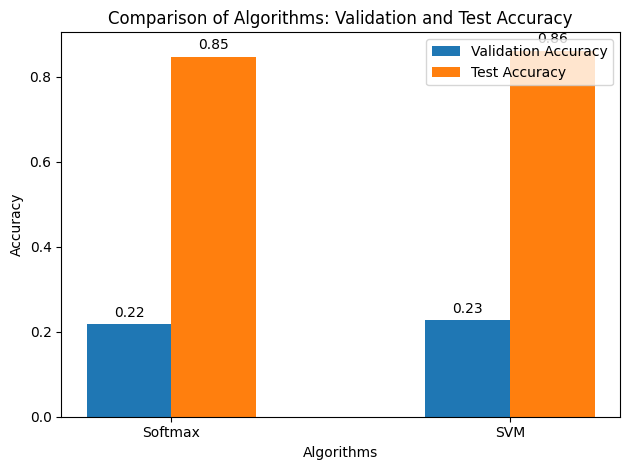

In [21]:
# Algorithm labels
plt_labels = ['Softmax', 'SVM']

# Validation accuracy values
validation_accuracies = [avg_softmax_accuracy, avg_svm_accuracy]

# Test accuracy values
test_accuracies = [softmax_test_accuracy, svm_test_accuracy]

# Bar width
width = 0.25

# X-axis positions for bars
x = np.arange(len(plt_labels))

# Create a figure and axis for the bar chart
fig, ax = plt.subplots()

# Bar chart for validation accuracies
rects1 = ax.bar(x - width/2, validation_accuracies, width, label='Validation Accuracy')

# Bar chart for test accuracies
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

# Set labels, title, and legend
ax.set_xlabel('Algorithms')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Algorithms: Validation and Test Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(plt_labels)
ax.legend()

# Add values on top of the bars
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Add values for both validation and test accuracies
add_values(rects1)
add_values(rects2)

# Show the bar chart
plt.tight_layout()
plt.show()

In [22]:
def reshape(image):
    image = image.reshape((image_size, image_size, 3))
    plt.gray()
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()

def softmax_make_prediction(index):
    # Make a prediction using Softmax Regression
    image = images[index]
    scores = np.dot(image, W_softmax)
    predicted_class = np.argmax(scores)
    reshape(image)
    # Map the predicted class index back to class label
    predicted_label = class_labels[predicted_class]

    # Print the predicted label
    print(f'Predicted: {predicted_label}')
    print(f'Label: {list(label_mapping.keys())[list(label_mapping.values()).index(labels[index])]}')

def svm_make_prediction(index):
    image = images[index]
    scores = np.dot(image, W_svm)
    predicted_class = np.argmax(scores)
    reshape(image)
    # Map the predicted class index back to class label
    predicted_label = class_labels[predicted_class]
    
    # Print the predicted label
    print(f'Predicted: {predicted_label}')
    print(f'Label: {list(label_mapping.keys())[list(label_mapping.values()).index(labels[index])]}')


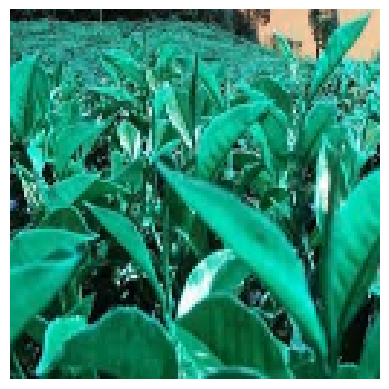

Predicted: tea
Label: tea


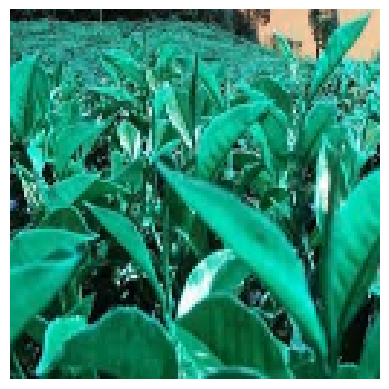

Predicted: tea
Label: tea


In [23]:
index = 700
softmax_make_prediction(index)
svm_make_prediction(index)